# Analyzing  Vektis open data
This jupyter Notebook used some of the open data from Vektis (https://www.vektis.nl/intelligence/open-data).

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def ecdf(data):
    """Compute ECDF (Empirical cumulative distribution function) for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

def importVektisDataMunicipalities (online, yearAnalysis, nameAnalysis, chunksize):
    """import the correct CSV file for municipalities and return a pandas DataFrame. Just keeps information about 
    the name of the municipality, gender, age-categories and number of insured years (as an alternative measure 
    for the number of people.
    
    Parameters:
        online (boolean): determines whether the file should be read from the website of Vektis or from the data-subfolder
        year (str): determines which year needs to be imported
        nameAnalysis (str): determines which column will be imported (and later analysed)
        chunksize (int): chunksize for processing the CSV file

    Returns:
    dataframe:the pandas DataFrame containing the requested information
    """
    if online:
        url = 'https://www.vektis.nl/uploads/Docs%20per%20pagina/Open%20Data%20Bestanden/Oud/OpenData%20' + yearAnalysis + '%20gem-5jcat.csv'
    else:
        url = 'OpenData ' + yearAnalysis + ' gem-5jcat.csv'

    #create empty DataFrame
    df_ret = pd.DataFrame()

    #create reader for chunk-wise reading of large .csv
    reader = pd.read_csv(url, sep=';', header=0, chunksize=chunksize, skiprows=[1])

    #only keep relevant information
    for chunk in reader:
        chunk = chunk[['GEMEENTENAAM','GESLACHT','LEEFTIJDSKLASSE',nameAnalysis,'AANTAL_VERZEKERDEJAREN']]
        df_ret = df_ret.append(chunk)

    return df_ret

def processMunicipality (df, municipalityAnalysis, nameAnalysis):
    """Processes the dataframe. Selects the indicated municipality, calculates the indicated column per insured year (as an
    alternative measure for the number of people), and strips the original two columns needed for that calculation.
    
    Parameters:
        df (dataframe): the dataframe containing the 'raw' data (from importVektisDataMunicipality)
        municipalityAnalysis: the name for the selected municipality
        nameAnalysis (str): determines which column will be imported (and later analysed)

    Returns:
    dataframe:the pandas DataFrame containing the requested information
    """
    df_ret = df.loc[df['GEMEENTENAAM'] == municipalityAnalysis, :]
    df_ret[analysekolom] = df_ret[nameAnalysis] / df_ret['AANTAL_VERZEKERDEJAREN']
    df_ret = df_ret.drop(['AANTAL_VERZEKERDEJAREN',nameAnalysis], axis=1)
    
    return df_ret

def calculateCountryAverage(df, nameAnalysis):
    """Processes the dataframe. Calculates the indicated column per insured year (as an alternative measure for the number
    of people), and strips the original two columns needed for that calculation.
    
    Parameters:
        df (dataframe): the dataframe containing the 'raw' data (from importVektisDataMunicipality)
        nameAnalysis (str): determines which column will be imported (and later analysed)

    Returns:
    dataframe:the pandas DataFrame containing the requested information
    """
    df_ret = df.pivot_table(index=['GEMEENTENAAM'], values=[nameAnalysis,'AANTAL_VERZEKERDEJAREN'], aggfunc=sum)
    df_ret[analysekolom] = df_ret[nameAnalysis] / df_ret['AANTAL_VERZEKERDEJAREN']
    df_ret = df_ret.drop(['AANTAL_VERZEKERDEJAREN',nameAnalysis], axis=1)

    return df_ret

def calculateCountryAveragePerGenderandAgeCategory(df, nameAnalysis):
    """Processes the dataframe. Calculates the indicated column per insured year (as an alternative measure for the number
    of people) per gender and age category, and strips the original two columns needed for that calculation.
    
    Parameters:
        df (dataframe): the dataframe containing the 'raw' data (from importVektisDataMunicipality)
        nameAnalysis (str): determines which column will be imported (and later analysed)

    Returns:
    dataframe:the pandas DataFrame containing the requested information
    """
    df_ret = df.pivot_table(index=['GESLACHT','LEEFTIJDSKLASSE'], values=[nameAnalysis,'AANTAL_VERZEKERDEJAREN'], aggfunc=sum)
    df_ret[analysekolom] = df_ret[nameAnalysis] / df_ret['AANTAL_VERZEKERDEJAREN'] #Caveat warning. Why?
    df_ret = df_ret.drop(['AANTAL_VERZEKERDEJAREN',nameAnalysis], axis=1)
    df_ret = df_ret.reset_index()
    
    return df_ret

def calculatePercentilesPerGenderandAgeCategory(df, nameAnalysis):
    """Calculates the 2.5%, 50% en 97.5% percentiles for the indicated column per insured year (as an alternative 
    measure for the number of people) per gender and age category.
    """
    df_ret = df[['GESLACHT','LEEFTIJDSKLASSE','GEMEENTENAAM']]
    df_ret[analysekolom] = df[nameAnalysis] / df['AANTAL_VERZEKERDEJAREN'] #Caveat warning. Why?
    df_ret = df_ret.pivot_table(index=['GESLACHT','LEEFTIJDSKLASSE'], columns='GEMEENTENAAM', values=[analysekolom], aggfunc=sum)
    df_ret['p2_5'] = df_ret.quantile(2.5/100, axis=1)
    df_ret['p97_5'] = df_ret.quantile(97.5/100, axis=1)
    #df_ret.columns = df_ret.columns.droplevel(1)
    #df_ret = df_ret[['p2_5','p97_5']]
    df_ret.reset_index(inplace=True)
    
    return df_ret

def plotSpreads(df, nameAnalysis):
    """Plots three different plots for the provide (single column) Dataframe: (1) the PDF (Probability Density Function, (2) the boxplot
    , and (3) the ECDF (Empirical cumulative distribution function)

    Parameters:
        df (dataframe): the dataframe containing the single column dataframe
        nameAnalysis (str): used for showing the proper title
    """
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.suptitle('Plots for the average ' + nameAnalysis + ' per AANTAL_VERZEKERDEJAREN around the country')
    #Probability Density Functions (PDF)
    _ = df.plot.kde(ax=axes[0])
    #Box plot
    _ = df.plot(ax=axes[1], kind='box')
    _ = axes[1].set_xticks([])

    plt.show()

    x,y = ecdf(df)
    _ = plt.plot(x, y, marker='.', linestyle='none')
    _ = plt.ylabel('ECDF')
    _ = plt.margins(0.02) # Keeps data off plot edges
    plt.show()
    
def plotPopulationPyramid(df_municipality, df_country, df_percentiles, municipalityAnalysis, nameAnalysis, yearAnalysis):
    """Plot a 'population pyramid' of the country averages includingcorresponding error bars AND the values from
    the selected municipality

    Parameters:
        df_municipality (dataframe): the dataframe containing information about the selected municipality
        df_country (dataframe): the dataframe containing the information about the country averages
        df_percentiles (dataframe): the dataframe containing the information about the 2.5% and 97.5% percentiles
        municipalityAnalysis (str): used for showing the proper title and creating the proper filename for export
        nameAnalysis (str): used for showing the proper title
        yearAnalysis (str): used for showing the proper title and creating the proper filename for export

    """
    # X contains the list of different age-categories
    X = np.array(df_municipality[df_municipality['GESLACHT'] == 'V']['LEEFTIJDSKLASSE'])

    # Transfer the information to specific men / women dataframes. We make sure all age categories are used by initializing a
    # dataframe with all labels and '0' value
    df_men_pop = df_municipality[df_municipality['GESLACHT'] == 'M'].set_index('LEEFTIJDSKLASSE').sort_index()
    df_men_pop = pd.DataFrame(X).set_index(0).join(df_men_pop, how='left').fillna(0)[analysekolom]
    
    df_women_pop = df_municipality[df_municipality['GESLACHT'] == 'V'].set_index('LEEFTIJDSKLASSE').sort_index()
    df_women_pop = pd.DataFrame(X).set_index(0).join(df_women_pop, how='left').fillna(0)[analysekolom]
    
    df_men_pop_ave  = df_country[df_country['GESLACHT'] == 'V'][analysekolom]
    df_women_pop_ave= df_country[df_country['GESLACHT'] == 'M'][analysekolom]

    # We make error-bars containing the 95% confidence intervals by making a tuple of arrays
    error_M = (-df_percentiles[df_percentiles['GESLACHT'] == 'M'][['p2_5']].values, 
               -df_percentiles[df_percentiles['GESLACHT'] == 'M'][['p97_5']].values)
    
    error_V = (df_percentiles[df_percentiles['GESLACHT'] == 'V'][['p2_5']].values,
               df_percentiles[df_percentiles['GESLACHT'] == 'V'][['p97_5']].values)

    # Now that we have used the list of age-groups to make sure all entries have a value, we can - for no other reason 
    # than that it just looks nicer - strip the last part of these labels.
    X = np.char.rpartition(X.astype('str'),' ')[:,0]
    X[-1] = '90+'

    # Convert the dataframes to a Numpy Array for plotting purposes
    women_pop = np.array( df_women_pop.values )
    men_pop   = np.array( df_men_pop.values )
    women_pop_ave = np.array( df_women_pop_ave.values )
    men_pop_ave   = np.array( df_men_pop_ave.values )

    # Now, we finally plot
    fig, ax = plt.subplots(figsize=(20,10))
    _ = plt.barh(X, women_pop, color = 'r', edgecolor='r', alpha=0.3)
    _ = plt.barh(X, -men_pop, color = 'b', edgecolor='b', alpha=0.3)
    _ = plt.barh(X, women_pop_ave, edgecolor = 'r', xerr=error_V,  ecolor='r', fill=False)
    _ = plt.barh(X, -men_pop_ave, edgecolor = 'b', xerr=error_M,  ecolor='b', fill=False)

    xlocs, xlabs = plt.xticks()
    _ = plt.xticks(xlocs, np.absolute(xlocs))
    _ = plt.xlabel(analysekolom)
    _ = plt.ylabel('leeftijdsklasse (jaar)')
    _ = plt.title(municipalityAnalysis + ' vs. landelijk gemiddelde (' + yearAnalysis + ')')
    _ = ax.xaxis.grid()
    
    if nameAnalysis == 'KOSTEN_FARMACIE':
        _ = ax.set_xlim(-3000,3000)

    if export:
        plt.savefig('data/' + municipalityAnalysis + ' (' + yearAnalysis + ')' + '.png')

    plt.show()

Set the parameters

In [18]:
# When True, all steps will be performed as one, the resulting population pyramid will be shown at once
allInOne = False

# When True, the code will try to connect to the data-files through http.
# When False, make sure to download the files to the 'data' folder
online = True

# When True, the code will save a few of the acquired DataFrames to csv for further analysis in e.g. Excel
export = True

analysejaar = '2016'
analysegemeente = 'GOUDA'
analysenaam = 'KOSTEN_FARMACIE'
analysekolom = analysenaam + ' per AANTAL_VERZEKERDEJAREN'

#KOSTEN_FARMACIE,KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG,KOSTEN_HUISARTS_CONSULT,KOSTEN_HULPMIDDELEN,KOSTEN_MONDZORG,
#KOSTEN_PARAMEDISCHE_ZORG_FYSIOTHERAPIE,KOSTEN_KRAAMZORG,KOSTEN_VERLOSKUNDIGE_ZORG

c:\users\wouter\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\wouter\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


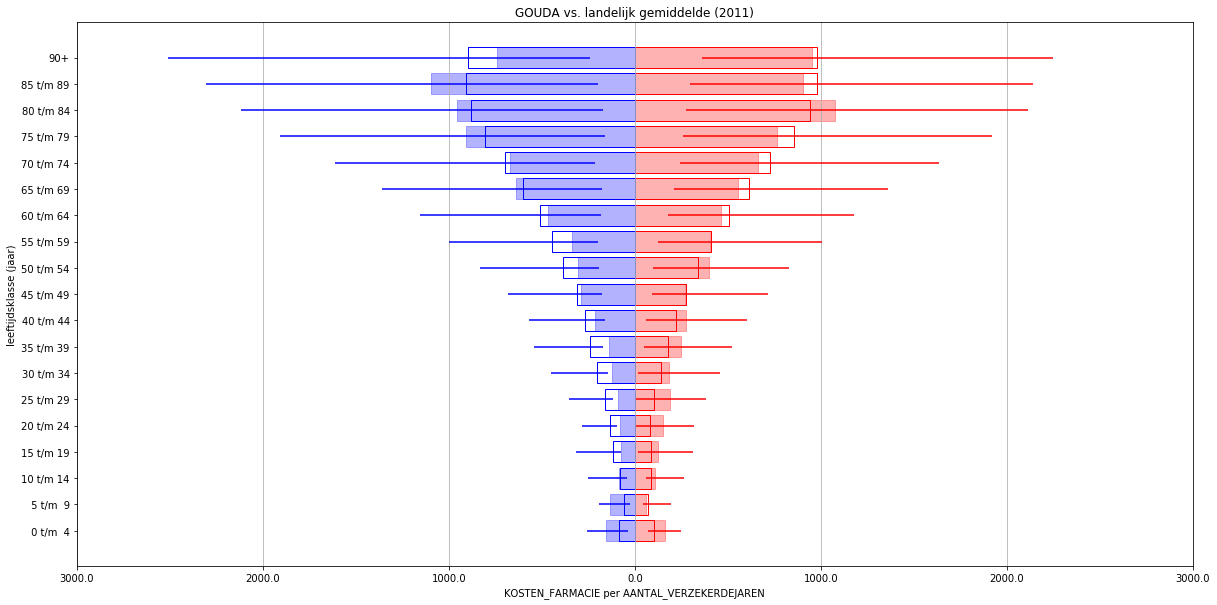

In [35]:
#Will be False after the first calculations are made, removing necessity to do the same things over and over again
firstPass = True
currentYear = ''
currentAnalysis = ''

def allInOne (yearAnalysis, municipalityAnalysis, nameAnalysis):
    global currentYear, currentAnalysis
    """Perform full analysis in one go."""
    if yearAnalysis != currentYear or nameAnalysis != currentAnalysis:
        firstPass = True
    if firstPass:
        df = importVektisDataMunicipalities(online, yearAnalysis, nameAnalysis, 10000)
        df_analysis2 = calculateCountryAveragePerGenderandAgeCategory(df, nameAnalysis)
        df_analysis3 = calculateCountryAverage(df, nameAnalysis)
        #plotSpreads(df_analysis3[analysekolom], analysenaam)
        df_analysis6 = calculatePercentilesPerGenderandAgeCategory(df, nameAnalysis)
        
        currentYear = yearAnalysis
        currentAnalysis = nameAnalysis
        analysekolom = nameAnalysis + ' per AANTAL_VERZEKERDEJAREN'
        firstPass = False
    
    df_analysis1 = processMunicipality(df, municipalityAnalysis, nameAnalysis)
    plotPopulationPyramid(df_analysis1, df_analysis2, df_analysis6, municipalityAnalysis, nameAnalysis, yearAnalysis)

allInOne('2011','GOUDA','KOSTEN_FARMACIE')

Let's import the information about municipalities.

In [22]:
df = importVektisDataMunicipalities(online, analysejaar, analysenaam, 10000)
df.head()

,GEMEENTENAAM,GESLACHT,LEEFTIJDSKLASSE,KOSTEN_FARMACIE,AANTAL_VERZEKERDEJAREN
0,AA EN HUNZE,M,0 t/m 4 jaar,40697.16,457.44
1,AALBURG,M,0 t/m 4 jaar,37406.66,363.36
2,AALSMEER,M,0 t/m 4 jaar,78495.82,749.31
3,AALTEN,M,0 t/m 4 jaar,76760.38,563.76
4,ACHTKARSPELEN,M,0 t/m 4 jaar,42450.54,675.92


df_analysis1 contains information about the selected municipality.

In [23]:
df_analysis1 = processMunicipality(df, analysegemeente, analysenaam)
df_analysis1.head()

c:\users\wouter\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,GEMEENTENAAM,GESLACHT,LEEFTIJDSKLASSE,KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN
117,GOUDA,M,0 t/m 4 jaar,125.834363
497,GOUDA,M,5 t/m 9 jaar,87.535086
877,GOUDA,M,10 t/m 14 jaar,68.984698
1257,GOUDA,M,15 t/m 19 jaar,55.451689
1637,GOUDA,M,20 t/m 24 jaar,95.810102


df_analysis2 contains information about the country-average.

In [24]:
df_analysis2 = calculateCountryAveragePerGenderandAgeCategory(df, analysenaam)
df_analysis2.head()

,GESLACHT,LEEFTIJDSKLASSE,KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN
0,M,0 t/m 4 jaar,102.442794
1,M,5 t/m 9 jaar,56.292721
2,M,10 t/m 14 jaar,71.561107
3,M,15 t/m 19 jaar,72.377775
4,M,20 t/m 24 jaar,73.686380


df_analysis3 contains the analysed value per municipality

In [25]:
df_analysis3 = calculateCountryAverage(df, analysenaam)
df_analysis3.head()

,KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN
GEMEENTENAAM,
AA EN HUNZE,261.462415
AALBURG,241.848455
AALSMEER,238.232386
AALTEN,272.151275
ACHTKARSPELEN,259.630077


Let's do some graphical inspection of the averages around the country

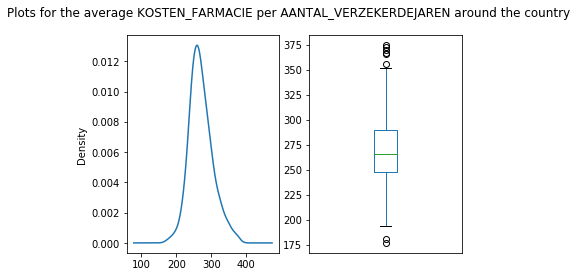

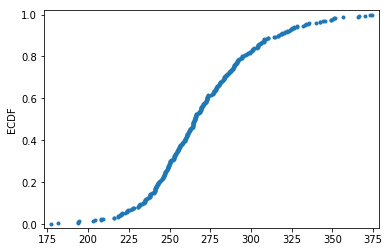

In [28]:
plotSpreads(df_analysis3[analysekolom], analysenaam)

df_analysis6 calculates the median and 95% confidence interval for the selected values

In [33]:
df_analysis6 = calculatePercentilesPerGenderandAgeCategory(df, analysenaam)
df_analysis6.head()

c:\users\wouter\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


GESLACHT LEEFTIJDSKLASSE  \
GEMEENTENAAM                            
0                   M   0 t/m  4 jaar   
1                   M   5 t/m  9 jaar   
2                   M  10 t/m 14 jaar   
3                   M  15 t/m 19 jaar   
4                   M  20 t/m 24 jaar   

             KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN              \
GEMEENTENAAM                                AA EN HUNZE     AALBURG   
0                                             88.967209  102.946554   
1                                             75.453074   36.127342   
2                                             66.446395   39.106534   
3                                             55.505119   61.900493   
4                                             59.556970  111.084539   

                                                                               \
GEMEENTENAAM    AALSMEER      AALTEN ACHTKARSPELEN ALBLASSERDAM ALBRANDSWAARD   
0             104.757470  136.157904     62.804089   212.904964     88.854035   
1              51.745594   46.703477     57.632445   138.089721     38.275237   
2              53.319196  153.746450     54.747433    94.214094     60.713865   
3              62.198733   58.920595     66.253229    78.040592     55.063284   
4              56.042447   69.342270     57.652438    60.482191     64.333514   

                         ...                                                  \
GEMEENTENAAM    ALKMAAR  ... ZOETERWOUDE    ZUIDHORN    ZUIDPLAS     ZUNDERT   
0             71.782126  ...   61.768129  136.774010  113.996986  104.151198   
1             39.642356  ...   51.737605   71.592262   62.019835  100.648981   
2             54.297373  ...   51.695398   44.417982  133.147184   72.387007   
3             53.671213  ...  189.600317   55.577309   85.901260   50.253422   
4             52.966110  ...   67.300898   49.853168   82.983255   91.748586   

                                                                      p2_5  \
GEMEENTENAAM     ZUTPHEN ZWARTEWATERLAND ZWIJNDRECHT     ZWOLLE              
0              99.396195       53.324120  112.215033  85.161142  48.970525   
1              51.729957       52.480160   83.038275  41.591873  28.584116   
2             171.125601      172.348767  101.803583  55.738225  35.364180   
3             107.338986       97.352790   62.275009  60.714926  37.624131   
4              54.380715       62.628333   59.488461  73.045906  34.090244   

                   p97_5  
GEMEENTENAAM              
0             197.668280  
1             106.799315  
2             165.391967  
3             169.214668  
4             154.264275  

[5 rows x 384 columns]

Let's find out which municipalities are outside the 95% confidence interval...

In [34]:
p2_5, p97_5 = np.percentile(df_analysis3,[2.5,97.5])
print( df_analysis3[ df_analysis3[analysekolom] < p2_5 ].sort_values(analysekolom) )
print( df_analysis3[ df_analysis3[analysekolom] > p97_5 ].sort_values(analysekolom, ascending=False) )

if export:
    df_analysis1.to_csv('data/df_vektis_demography_' + analysejaar + '_' + analysegemeente + '.csv', decimal=',', index=True)
    df_analysis2.to_csv('data/df_vektis_demography_' + analysejaar + '.csv', decimal=',', index=True)
    df_analysis3.to_csv('data/df_vektis_' + analysejaar + '.csv', decimal=',', index=True)
    df_analysis3[ df_analysis3[analysekolom] < p2_5 ].append(df_analysis3[ df_analysis3[analysekolom] > p97_5 ]).reset_index().to_csv('data/outliers_' + analysejaar + '.csv', decimal=',', index=False)
    df_analysis6.to_csv('data/df_vektis_percentiles' + analysejaar + '.csv', decimal=',', index=True)

                 KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN
GEMEENTENAAM                                               
URK                                              176.936933
DRECHTERLAND                                     181.318112
KOGGENLAND                                       193.959460
STAPHORST                                        194.108619
ZEEWOLDE                                         194.568343
LANGEDIJK                                        202.751019
RENSWOUDE                                        204.327670
ROZENDAAL                                        207.819918
MIDDEN-DELFLAND                                  208.181511
LANSINGERLAND                                    209.423975
              KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN
GEMEENTENAAM                                            
HEERLEN                                       374.538499
KERKRADE                                      372.765940
DELFZIJL                                      370.16

In [ ]:
plotPopulationPyramid(df_analysis1, df_analysis2, df_analysis6, analysegemeente, analysenaam, analysejaar)